In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from scipy.signal import find_peaks, medfilt, butter, sosfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal

2025-01-06 23:17:18.052482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data=pd.read_csv("/Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv") #add path to csv file
data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [3]:
desired_columns = ['patient_id', 'scp_codes', 'filename_hr','baseline_drift','static_noise','burst_noise','electrodes_problems','extra_beats']  # Replace these with the actual column names you want
separate_data = data[desired_columns].copy()
df = pd.DataFrame(separate_data)

#making a function to extract first key of the 'scp_codes' column as it contains the diagnose 
def extract_first_key(scp_codes):
    scp_dict = eval(scp_codes)
    first_key = next(iter(scp_dict.keys()), None)
    return first_key

# Apply function to create new column with first key
df['scp_codes'] = df['scp_codes'].apply(extract_first_key)

print(df)

       patient_id scp_codes                filename_hr  baseline_drift  \
0         15709.0      NORM  records500/00000/00001_hr             NaN   
1         13243.0      NORM  records500/00000/00002_hr             NaN   
2         20372.0      NORM  records500/00000/00003_hr             NaN   
3         17014.0      NORM  records500/00000/00004_hr    , II,III,AVF   
4         17448.0      NORM  records500/00000/00005_hr   , III,AVR,AVF   
...           ...       ...                        ...             ...   
21832     17180.0       NDT  records500/21000/21833_hr             NaN   
21833     20703.0      NORM  records500/21000/21834_hr             NaN   
21834     19311.0     ISCAS  records500/21000/21835_hr             NaN   
21835      8873.0      NORM  records500/21000/21836_hr             NaN   
21836     11744.0      NORM  records500/21000/21837_hr             NaN   

      static_noise burst_noise electrodes_problems extra_beats  
0        , I-V1,           NaN                

In [4]:
#geting the path of each record present in the csv file and save it in 'filename_lr' column 
filename=data['filename_lr']
data['filename_hr'] = [os.path.join("/Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/", filename)
                       for filename in data['filename_lr']]
print(data['filename_hr'])
data.head()

0        /Users/vardhan/Downloads/ptb-xl-a-large-public...
1        /Users/vardhan/Downloads/ptb-xl-a-large-public...
2        /Users/vardhan/Downloads/ptb-xl-a-large-public...
3        /Users/vardhan/Downloads/ptb-xl-a-large-public...
4        /Users/vardhan/Downloads/ptb-xl-a-large-public...
                               ...                        
21832    /Users/vardhan/Downloads/ptb-xl-a-large-public...
21833    /Users/vardhan/Downloads/ptb-xl-a-large-public...
21834    /Users/vardhan/Downloads/ptb-xl-a-large-public...
21835    /Users/vardhan/Downloads/ptb-xl-a-large-public...
21836    /Users/vardhan/Downloads/ptb-xl-a-large-public...
Name: filename_hr, Length: 21837, dtype: object


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,/Users/vardhan/Downloads/ptb-xl-a-large-public...
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,/Users/vardhan/Downloads/ptb-xl-a-large-public...
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,/Users/vardhan/Downloads/ptb-xl-a-large-public...
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,/Users/vardhan/Downloads/ptb-xl-a-large-public...
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,/Users/vardhan/Downloads/ptb-xl-a-large-public...


In [ ]:
#trying a separate record 
b=r"/Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/00000/00004_lr"
record = wfdb.rdrecord(b,sampfrom = 0,sampto=1000
                       ,channels=[1,3]) 
wfdb.plot_wfdb(record=record, title='first attempt') 
display(record.__dict__)

In [ ]:
# itrating over each record a plot it
for i in data['filename_hr']:
    record = wfdb.rdrecord(i,sampfrom = 100,sampto=200 ,channels=[0,1])
    wfdb.plot_wfdb(record=record, title='first attempt') 

In [5]:
#making a separate DataFrame that contains specific columns "desired columns"

desired_columns = ['patient_id', 'scp_codes', 'filename_hr','baseline_drift','static_noise','burst_noise','electrodes_problems','extra_beats']  # Replace these with the actual column names you want
separate_data = data[desired_columns].copy()
df = pd.DataFrame(separate_data)

#making a function to extract first key of the 'scp_codes' column as it contains the diagnose 
def extract_first_key(scp_codes):
    scp_dict = eval(scp_codes)
    first_key = next(iter(scp_dict.keys()), None)
    return first_key

# Apply function to create new column with first key
df['scp_codes'] = df['scp_codes'].apply(extract_first_key)

print(df)

       patient_id scp_codes  \
0         15709.0      NORM   
1         13243.0      NORM   
2         20372.0      NORM   
3         17014.0      NORM   
4         17448.0      NORM   
...           ...       ...   
21832     17180.0       NDT   
21833     20703.0      NORM   
21834     19311.0     ISCAS   
21835      8873.0      NORM   
21836     11744.0      NORM   

                                             filename_hr  baseline_drift  \
0      /Users/vardhan/Downloads/ptb-xl-a-large-public...             NaN   
1      /Users/vardhan/Downloads/ptb-xl-a-large-public...             NaN   
2      /Users/vardhan/Downloads/ptb-xl-a-large-public...             NaN   
3      /Users/vardhan/Downloads/ptb-xl-a-large-public...    , II,III,AVF   
4      /Users/vardhan/Downloads/ptb-xl-a-large-public...   , III,AVR,AVF   
...                                                  ...             ...   
21832  /Users/vardhan/Downloads/ptb-xl-a-large-public...             NaN   
21833  /Users/vardh

In [6]:
# as we only make a binary classification with 'IMI' disease we group by the classes and then take equal parts of 'IMI' and 'NORM' so we could have balanced data
grouped = df.groupby(df['scp_codes'])
X_data = []
for scp_codes in ['NORM', 'IMI']:
    X_data.append(grouped.get_group(scp_codes).sample(n=2317)) 
result = pd.concat(X_data) 
print(result)
print(len(result))

       patient_id scp_codes  \
4772      17740.0      NORM   
13146     20548.0      NORM   
1164       1413.0      NORM   
12435      3404.0      NORM   
13682     14242.0      NORM   
...           ...       ...   
10613     21413.0       IMI   
9718      20718.0       IMI   
15526     18830.0       IMI   
18434     11088.0       IMI   
9021       5194.0       IMI   

                                             filename_hr baseline_drift  \
4772   /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
13146  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
1164   /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
12435  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
13682  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
...                                                  ...            ...   
10613  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
9718   /Users/vardhan/Downl

In [7]:
#the data contain electrode problems and i want toremove them as they are so small persentage
print(result['electrodes_problems'].value_counts()) 

# Define the condition to filter rows based on the 'electrodes_problems' column
condition = ~result['electrodes_problems'].isin(['V5', 'V1', 'V3','v6????','aVL???','V5,V6','V6'])

# Filter rows based on the condition
result_filtered = result[condition]

print(result_filtered.count())

electrodes_problems
V5,V6    1
V5       1
V3       1
V1       1
Name: count, dtype: int64
patient_id             4630
scp_codes              4630
filename_hr            4630
baseline_drift          299
static_noise            735
burst_noise             136
electrodes_problems       0
extra_beats             416
dtype: int64


In [8]:
# encode the target value so it can be processed using CNN model
label_map = {'IMI': 0, 'NORM': 1}

# Applying the map function to the 'scp_codes' column
result_filtered['scp_codes'] = result_filtered['scp_codes'].map(label_map)

# Printing the modified DataFrame
print(result_filtered)

       patient_id  scp_codes  \
4772      17740.0          1   
13146     20548.0          1   
1164       1413.0          1   
12435      3404.0          1   
13682     14242.0          1   
...           ...        ...   
10613     21413.0          0   
9718      20718.0          0   
15526     18830.0          0   
18434     11088.0          0   
9021       5194.0          0   

                                             filename_hr baseline_drift  \
4772   /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
13146  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
1164   /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
12435  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
13682  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
...                                                  ...            ...   
10613  /Users/vardhan/Downloads/ptb-xl-a-large-public...            NaN   
9718   /Users/v

/var/folders/_s/1t7zmmr96xq167zjqtdl23br0000gn/T/ipykernel_2416/587958758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered['scp_codes'] = result_filtered['scp_codes'].map(label_map)


In [9]:
# normalization, r_peak detection, filters applying, beat spliting and saving functions 
def detect_r_peaks(ecg_signal):
    r_peaks, _ = find_peaks(ecg_signal, height=0, distance=50)
    return r_peaks

def segment_beats(ecg_signal, r_peaks, max_length):
    beats = []
    for i in range(len(r_peaks) - 1):
        beat_start = r_peaks[i]
        beat_end = r_peaks[i + 1]
        beat = ecg_signal[beat_start:beat_end]
        if len(beat) > max_length:
            beat = beat[:max_length]
        elif len(beat) < max_length:
            beat = np.pad(beat, (0, max_length - len(beat)), 'constant')
        beats.append(beat)
    return beats

def z_score_normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    normalized_signal = (signal - mean) / std
    return normalized_signal

def process_ecg_record(record_path, max_length):
    record = wfdb.rdrecord(record_path)
    num_leads = record.p_signal.shape[1]
    
    # Use the first lead as the reference lead to detect R-peaks
    lead_signal_ref = record.p_signal[:, 0]

    # Apply median filter
    filtered_signal_median_ref = medfilt(lead_signal_ref, kernel_size=3)

    # Apply high-pass filter to correct baseline drift
    sos_ref = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
    filtered_signal_ref = sosfilt(sos_ref, filtered_signal_median_ref)

    # Apply Z-score normalization
    normalized_signal_ref = z_score_normalize(filtered_signal_ref)

    # Detect R-peaks on the normalized signal of the reference lead
    r_peaks_indices = detect_r_peaks(normalized_signal_ref)

    all_beats = [[] for _ in range(num_leads)]

    for i in range(num_leads):
        lead_signal = record.p_signal[:, i]

        # Apply median filter
        filtered_signal_median = medfilt(lead_signal, kernel_size=3)

        # Apply high-pass filter to correct baseline drift
        sos = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
        filtered_signal = sosfilt(sos, filtered_signal_median)

        # Apply Z-score normalization
        normalized_signal = z_score_normalize(filtered_signal)

        # Segment the ECG signal into beats using the R-peaks from the reference lead
        beats = segment_beats(normalized_signal, r_peaks_indices, max_length)

        all_beats[i].extend(beats)

    # Combine beats from all leads into a single array with shape (num_beats, max_length, num_leads)
    num_beats = len(all_beats[0])
    combined_beats = np.zeros((num_beats, max_length, num_leads), dtype=np.float32)
    for i in range(num_leads):
        combined_beats[:, :, i] = all_beats[i][:num_beats]

    return combined_beats
#a code to itrate over each record and applying the above functions then saving them in array
def process_ecg_records_from_dataframe(dataframe, max_length):
    all_records = []
    all_labels = []
    for idx, row in dataframe.iterrows():
        record_path = row['filename_hr']
        label = row['scp_codes']  # Assuming 'scp_codes' is the label column
        print(f"Processing record: {record_path}")
        all_records.append(process_ecg_record(record_path, max_length))
        all_labels.append(label)
    return all_records, all_labels
# creat a dataset to make it easier to split into train, validation and test
def create_dataset(ecg_records, labels):
    X = []
    y = []
    for record, label in zip(ecg_records, labels):
        X.extend(record)  # No need to stack, since each beat is already processed
        y.extend([label] * record.shape[0])  # Assign the label to each beat
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
#applying all the above functions 
df = result_filtered  
# Define the maximum length for beats
max_length = 500

# Split the DataFrame into train(70%), validation(15%), and test(15%) sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Process all ECG records listed in each subset
print("Processing Training Set")
train_records, train_labels = process_ecg_records_from_dataframe(train_df, max_length)

print("Processing Validation Set")
val_records, val_labels = process_ecg_records_from_dataframe(val_df, max_length)

print("Processing Test Set")
test_records, test_labels = process_ecg_records_from_dataframe(test_df, max_length)

# Create datasets for training, validation, and testing
X_train, y_train = create_dataset(train_records, train_labels)
X_val, y_val = create_dataset(val_records, val_labels)
X_test, y_test = create_dataset(test_records, test_labels)

# Reshape the data to fit the CNN input shape
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Processing Training Set
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/15000/15943_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/10000/10670_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/14000/14416_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/15000/15398_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/09000/09646_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/15000/15361_lr
Processing record: /Users/vardhan/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records100/00000/00459_lr
Processing

In [11]:
print(y_train)

[1 1 1 ... 1 1 1]


In [12]:
num_classes=1 # binary classification 
# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=(500, 12),kernel_initializer=he_normal()),
    LeakyReLU(alpha=0.01), 
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=512, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Binary classification
])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 498, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 249, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 247, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 121, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 121, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 58, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 58, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 27, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 27, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       852,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,376,609 (5.25 MB)

 Trainable params: 1,376,609 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]


In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7690 - loss: 0.4755
Epoch 1: val_loss improved from inf to 0.28524, saving model to best_model.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 334s 909ms/step - accuracy: 0.7692 - loss: 0.4752 - val_accuracy: 0.8780 - val_loss: 0.2852
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.8891 - loss: 0.2599
Epoch 2: val_loss improved from 0.28524 to 0.26668, saving model to best_model.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 192s 625ms/step - accuracy: 0.8892 - loss: 0.2599 - val_accuracy: 0.8867 - val_loss: 0.2667
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9073 - loss: 0.2231
Epoch 3: val_loss improved from 0.26668 to 0.25420, saving model to best_model.keras
306/306 ━━━━━━━━━━━━━━━━━━━━ 208s 678ms/step - accuracy: 0.9073 - loss: 0.2231 - val_accuracy: 0.8886 - val_loss: 0.2542
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9149 - loss: 0.2023
Epoch 4: val_loss did not improve 

263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Confusion Matrix:
[[3951  384]
 [ 424 3636]]
Sensitivity: 0.8955665024630541
Specificity: 0.9114186851211072
F1 Score: 0.9
Precision: 0.9044776119402985
Recall: 0.8955665024630541


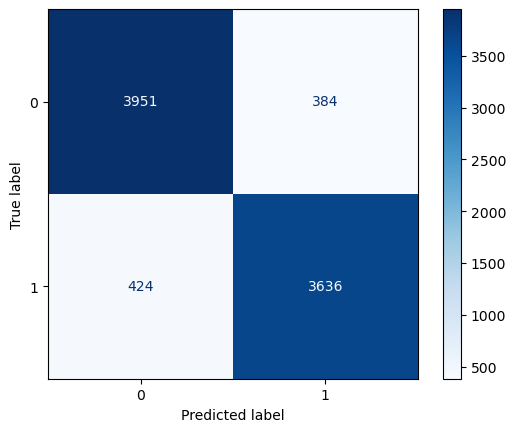

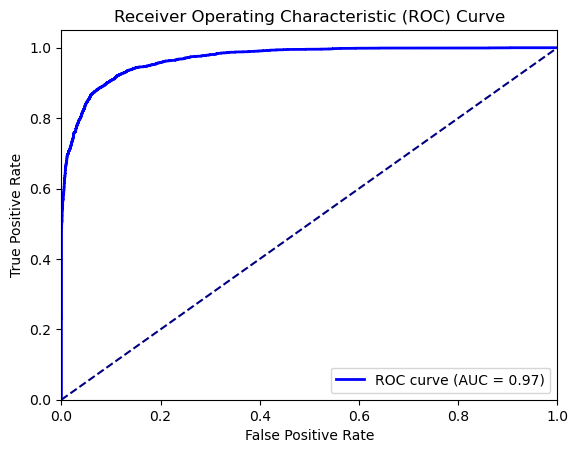

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4335
           1       0.90      0.90      0.90      4060

    accuracy                           0.90      8395
   macro avg       0.90      0.90      0.90      8395
weighted avg       0.90      0.90      0.90      8395



In [16]:
# Predict the labels for the test set
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues) 
print('Confusion Matrix:')
print(conf_matrix)

# Extracting true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print(f'Sensitivity: {sensitivity}')

# Calculate specificity
specificity = tn / (tn + fp)
print(f'Specificity: {specificity}')

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# Print the F1 score, precision, and recall
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# ROC and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

In [18]:
 # Define the callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/50
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9414 - loss: 0.1442
Epoch 1: val_accuracy improved from -inf to 0.88922, saving model to best_model.keras
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 197s 162ms/step - accuracy: 0.9414 - loss: 0.1441 - val_accuracy: 0.8892 - val_loss: 0.2968
Epoch 2/50
 492/1221 ━━━━━━━━━━━━━━━━━━━━ 1:48 149ms/step - accuracy: 0.9600 - loss: 0.1075

KeyboardInterrupt: 

263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9047 - loss: 0.2542
Test Loss: 0.2620791792869568
Test Accuracy: 0.9050625562667847
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step
Confusion Matrix:
[[4009  326]
 [ 471 3589]]
Sensitivity (Recall): 0.8839901477832512
Specificity: 0.92479815455594
F1 Score: 0.9000626959247648
Precision: 0.9167305236270753
Recall: 0.8839901477832512


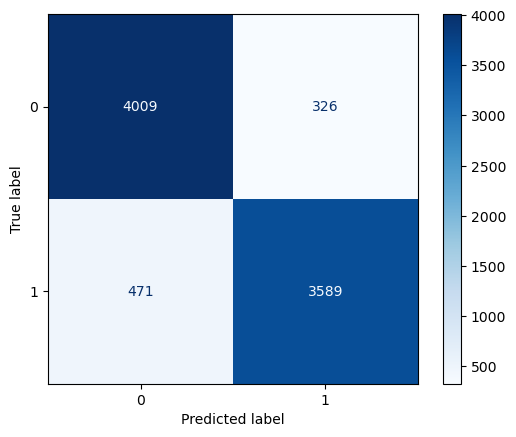

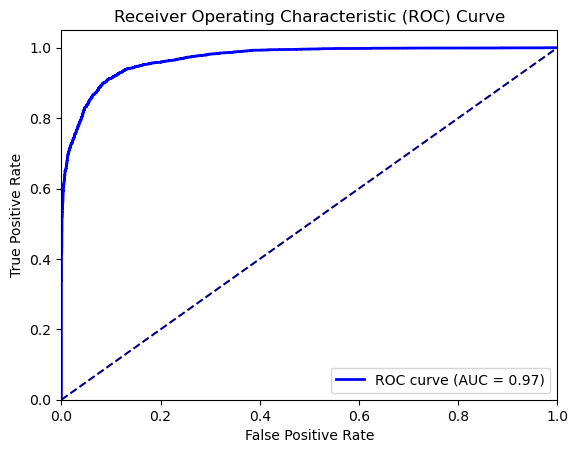

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4335
           1       0.92      0.88      0.90      4060

    accuracy                           0.91      8395
   macro avg       0.91      0.90      0.90      8395
weighted avg       0.91      0.91      0.90      8395



In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test set
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues)
print('Confusion Matrix:')
print(conf_matrix)

# Extracting true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print(f'Sensitivity (Recall): {sensitivity}')

# Calculate specificity
specificity = tn / (tn + fp)
print(f'Specificity: {specificity}')

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# Print the F1 score, precision, and recall
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# ROC and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))


In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, auc

# Calculate the metrics
test_loss, test_accuracy = model.evaluate(X_test, y_test)


# Predicted probabilities
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Extracting true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# ROC and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Calculate Precision-Recall AUC
precision_rec, recall_rec, _ = precision_recall_curve(y_test, y_pred_probs)

# Ensure the precision and recall are sorted in decreasing order for precision
# and increasing order for recall (as required by AUC)
if precision_rec[0] < precision_rec[-1]:
    precision_rec = precision_rec[::-1]
    recall_rec = recall_rec[::-1]
print("Model: CNN (PTB-XL, Time)\n")
pr_auc = auc(recall_rec, precision_rec)

# Create a summary DataFrame for each model
model_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'F1-Score', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        test_accuracy,
        sensitivity,
        specificity,
        f1,
        roc_auc,
        pr_auc
    ]
})

# Print the model summary
print(f"Model: {model}")
display(model_summary)


263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9047 - loss: 0.2542
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step
Model: CNN (PTB-XL, Time)

Model: <Sequential name=sequential, built=True>


,Metric,Score
0,Accuracy,0.905063
1,Sensitivity (Recall),0.883990
2,Specificity,0.924798
3,F1-Score,0.900063
4,ROC AUC,0.969453
5,Precision-Recall AUC,0.969664


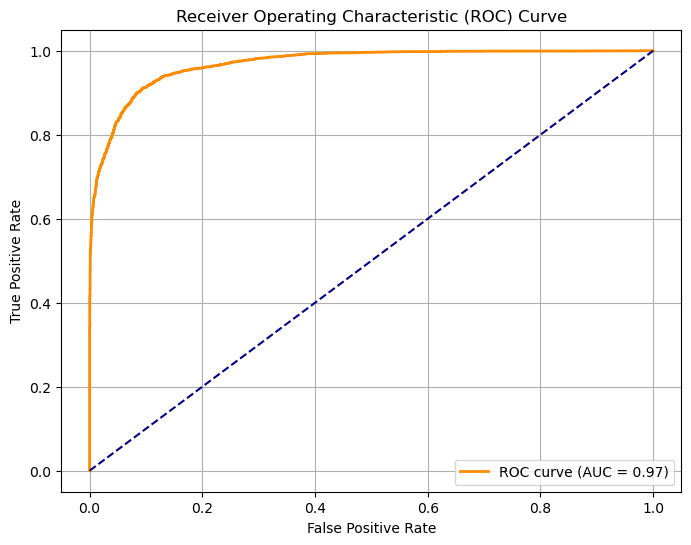

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have y_test and y_pred_probs

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
